In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important; }</style>"))

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import utils
from het_block import het
import simple_block as sim
from simple_block import simple
import jacobian as jac
# import nonlinear
import hank
# import determinacy as det

In [3]:
# Add Transfers function to households block
def transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule):    
    div = Div / np.sum(pi_e * div_rule) * div_rule
    tax = Tax / np.sum(pi_e * tax_rule) * tax_rule
    T = div - tax
    return T

household = hank.household.attach_hetinput(transfers)

In [21]:
ss['e_grid'], ss['pi_e'], ss['pi_e']*ss['e_grid'], np.sum(ss['pi_e']*ss['e_grid']), ss['Div']*ss['e_grid']

(array([0.25952913, 0.39037867, 0.58720002, 0.88325488, 1.32857484,
        1.99841649, 3.00597929]),
 array([0.015625, 0.09375 , 0.234375, 0.3125  , 0.234375, 0.09375 ,
        0.015625]),
 array([0.00405514, 0.036598  , 0.13762501, 0.27601715, 0.31138473,
        0.18735155, 0.04696843]),
 1.0,
 array([0.04325485, 0.06506311, 0.09786667, 0.14720915, 0.22142914,
        0.33306941, 0.50099655]))

In [10]:
# SS solver
def hank_ss(beta_guess=0.986, vphi_guess=0.8, r=0.005, eis=0.5, frisch=0.5, mu=1.2, B_Y=5.6, rho_s=0.966, sigma_s=0.5,
            kappa=0.1, phi=1.5, nS=7, amax=150, nA=500, tax_rule=None, div_rule=None):
    """Solve steady state of full GE model. Calibrate (beta, vphi) to hit target for interest rate and Y."""

    # set up grid
    a_grid = utils.agrid(amax=amax, n=nA)
    e_grid, pi_e, Pi = utils.markov_rouwenhorst(rho=rho_s, sigma=sigma_s, N=nS)
    
    # default incidence rules are proportional to skill
    if tax_rule is None:
        tax_rule = e_grid  # scale does not matter, will be normalized anyway
    if div_rule is None:
        div_rule = e_grid
    assert len(tax_rule) == len(div_rule) == len(e_grid), 'Incidence rules are inconsistent with income grid.'

    # solve analytically what we can
    B = B_Y
    w = 1 / mu
    Div = (1 - w)
    Tax = r * B
    T = transfers(pi_e, Div, Tax, e_grid, div_rule, tax_rule)

    # initialize guess for policy function iteration
    fininc = (1 + r) * a_grid + T[:, np.newaxis] - a_grid[0]
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis] + T[:, np.newaxis]
    Va = (1 + r) * (0.1 * coh) ** (-1 / eis)

    # residual function
    def res(x):
        beta_loc, vphi_loc = x
        # precompute constrained c and n which don't depend on Va
        c_const_loc, n_const_loc = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi_loc, Va)
        if beta_loc > 0.999 / (1 + r) or vphi_loc < 0.001:
            raise ValueError('Clearly invalid inputs')
        out = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta_loc, eis=eis,
                           Div=Div, Tax=Tax, frisch=frisch, vphi=vphi_loc, c_const=c_const_loc, n_const=n_const_loc,
                           tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
        return np.array([out['A'] - B, out['NS'] - 1])

    # solve for beta, vphi
    (beta, vphi), _ = utils.broyden_solver(res, np.array([beta_guess, vphi_guess]), noisy=False)

    # extra evaluation for reporting
    c_const, n_const = hank.solve_cn(w * e_grid[:, np.newaxis], fininc, eis, frisch, vphi, Va)
    ss = household.ss(Va=Va, Pi=Pi, a_grid=a_grid, e_grid=e_grid, pi_e=pi_e, w=w, r=r, beta=beta, eis=eis,
                      Div=Div, Tax=Tax, frisch=frisch, vphi=vphi, c_const=c_const, n_const=n_const,
                      tax_rule=tax_rule, div_rule=div_rule, ssflag=True)
    
    # check Walras's law
    walras = 1 - ss['C']
    assert np.abs(walras) < 1E-8
    
    # add aggregate variables
    ss.update({'B': B, 'phi': phi, 'kappa': kappa, 'Y': 1, 'rstar': r, 'Z': 1, 'mu': mu, 'L': 1, 'pi': 0,
               'walras': walras, 'ssflag': False})
    return ss

In [11]:
# Get SS values
ss = hank_ss()
ss.keys()

dict_keys(['vphi', 'a_grid', 'ssflag', 'frisch', 'w', 'e_grid', 'r', 'n_const', 'c_const', 'T', 'beta', 'eis', 'Pi', 'Va', 'pi_e', 'tax_rule', 'Tax', 'Div', 'div_rule', 'a', 'c', 'n', 'ns', 'N', 'A', 'C', 'NS', 'D', 'B', 'phi', 'kappa', 'Y', 'rstar', 'Z', 'mu', 'L', 'pi', 'walras'])

In [22]:
# Simple blocks - Benchmark
@simple
def firm(Y, w, Z, pi, mu, kappa):
    L = Y / Z
    Div = Y - w * L - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y
    return L, Div

@simple
def monetary(pi, rstar, phi):
    r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1 #(Fisher + Taylor)
    return r

@simple
def fiscal(r, B):
    Tax = r * B
    
    return Tax

@simple
def mkt_clearing(A, NS, C, L, Y, B, pi, mu, kappa):
    asset_mkt = A - B
    labor_mkt = NS - L
    goods_mkt = Y - C - mu/(mu-1)/(2*kappa) * np.log(1+pi)**2 * Y #(G=0 here!) 
    return asset_mkt, labor_mkt, goods_mkt

@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * np.log(1 + pi(+1)) / (1 + r(+1)) - np.log(1 + pi)
    return nkpc_res

In [23]:
# Solve for all jacobians (and, therefore, all IRFs)
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'Y']
targets = ['nkpc_res', 'asset_mkt', 'labor_mkt']

# general equilibrium jacobians
block_list = [firm, monetary, fiscal, nkpc, mkt_clearing, household] 
G = jac.get_G(block_list, exogenous, unknowns, targets, T, ss, save=True)

In [24]:
# What's in G? We have all endogenous variables and their responses to changes in exogenous variables (rstar, Z)
print(G.keys())
print(G['Y'].keys())

dict_keys(['pi', 'goods_mkt', 'C', 'L', 'r', 'Tax', 'Y', 'Div', 'A', 'N', 'w', 'NS'])
dict_keys(['rstar', 'Z'])


Text(0, 0.5, 'bp deviation from ss')

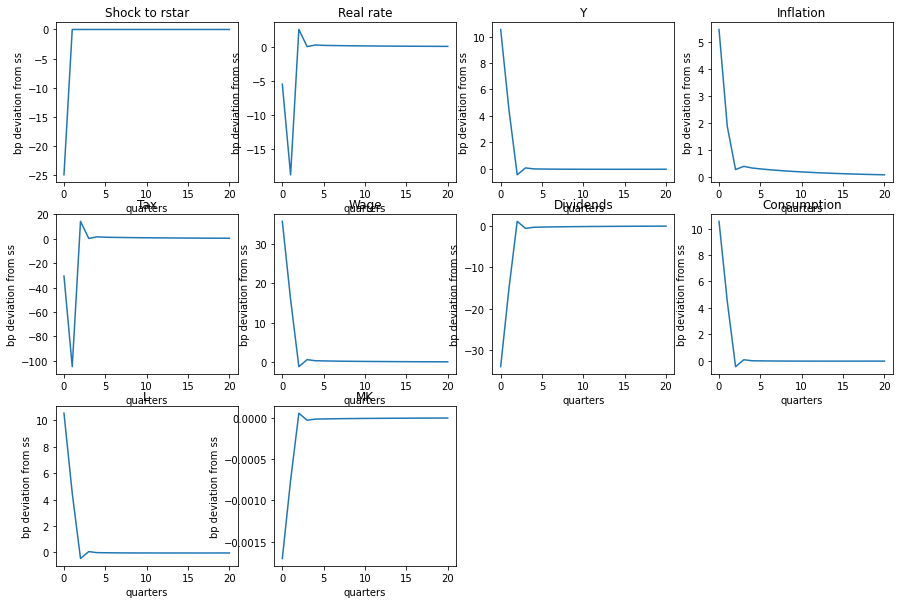

In [37]:
# Some charts: expansionary MP shock
drstar = -0.0025 * 0 ** (np.arange(T)[:, np.newaxis])

dr = G['r']['rstar'] @ drstar
dY = G['Y']['rstar'] @ drstar
dpi = G['pi']['rstar'] @ drstar
dTax = G['Tax']['rstar'] @ drstar
dw = G['w']['rstar'] @ drstar
dDiv = G['Div']['rstar'] @ drstar
dC = G['C']['rstar'] @ drstar
dL = G['L']['rstar'] @ drstar
dmk = G['goods_mkt']['rstar'] @ drstar

# dend_drstar = {}
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(3, 4, 1)
ax.plot(10000 * drstar[:21])
ax.set_title('Shock to rstar')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 2)
ax.plot(10000 * dr[:21])
ax.set_title(r'Real rate')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 3)
ax.plot(10000 * dY[:21])
ax.set_title(r'Y')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 4)
ax.plot(10000 * dpi[:21])
ax.set_title(r'Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 5)
ax.plot(10000 * dTax[:21])
ax.set_title(r'Tax')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 6)
ax.plot(10000 * dw[:21])
ax.set_title(r'Wage')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 7)
ax.plot(10000 * dDiv[:21])
ax.set_title(r'Dividends')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 8)
ax.plot(10000 * dC[:21])
ax.set_title(r'Consumption')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 9)
ax.plot(10000 * dL[:21])
ax.set_title(r'L')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax = fig.add_subplot(3, 4, 10)
ax.plot(10000 * dmk[:21])
ax.set_title(r'MK')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')